# ML4NLU Final Project
## Rumour Veracity Prediction
by Sarah Ackerschewski, Uygar Navruz, Hyunjun Park

This is a Notebook containing code for a rumour veracity task adapted from SemEval2017 Task 8 SubtaskB and SemEval2019 Task 7 SubtaskB. The data is taken from their [website](https://alt.qcri.org/semeval2017/task8/) and from [the Pheme project](https://figshare.com/articles/dataset/RumourEval_2019_data/8845580)

In [1]:
import os
import json
import pandas as pd
import numpy as np
import re
import pickle
import spacy
import random
import seaborn as sns 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, LSTM

from sklearn.metrics import precision_recall_fscore_support, accuracy_score, mean_squared_error
from math import sqrt

C:\Users\Lenovo\anaconda3\envs\rumoureval\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load spacy language model for lemmatization
#!python -m spacy download en_core_web_sm
nlp = spacy.load('en_core_web_sm')

In [3]:
def read_tweets(folder):
    tweet_dict = {}
    topics = os.listdir(folder)
    for topic in topics:
        tweets = os.listdir(folder + "/" + topic)
        
        for tweet in tweets:
            tmp_path = folder +"/"+ topic +"/" + tweet
            path = tmp_path + "/source-tweet/"+tweet+".json"
            f = open(path, "r")
            src_tweet = json.loads(f.read())
            key =str(src_tweet["id"]) +"_" + topic
            tweet_dict[key] = src_tweet["text"]

    # add labels directly
    labels = {}
    f1 = open("original_data/semeval2017-task8-dataset/traindev/rumoureval-subtaskB-dev.json","r")
    dev = json.loads(f1.read())
    f2 = open("original_data/semeval2017-task8-dataset/traindev/rumoureval-subtaskB-train.json","r")
    train = json.loads(f2.read())
    for id, label in dev.items():
        res = dict(filter(lambda item: id in item[0], tweet_dict.items()))
        labels[res.popitem()[0]] = label
    for id, label in train.items():
        res = dict(filter(lambda item: id in item[0], tweet_dict.items()))
        labels[res.popitem()[0]] = label
    
    d = {"id":tweet_dict.keys(), "text":tweet_dict.values()}
    tweet_df = pd.DataFrame(d)
    
    tweet_df["label"] = tweet_df["id"].map(labels)
    tweet_df.to_csv("merged_data/tweets.csv",sep=',')

In [4]:
def read_tweets19(folder):
    tweet_dict = {}
    topics = os.listdir(folder)
    tweets17 = pd.read_csv("merged_data/tweets.csv")
    for topic in topics:
        tweets = os.listdir(folder + "/" + topic)
        
        f1 = open("original_data/rumoureval-2019-training-data/train-key.json", "r")
        train_labels = json.loads(f1.read())
        train_labels = train_labels["subtaskbenglish"]
        
        f2 = open("original_data/rumoureval-2019-training-data/dev-key.json", "r")
        dev_labels = json.loads(f2.read())
        dev_labels = dev_labels["subtaskbenglish"]

        for tweet in tweets:
            tmp_path = folder +"/"+ topic +"/" + tweet
            path = tmp_path + "/source-tweet/"+tweet+".json"
            f = open(path, "r")
            src_tweet = json.loads(f.read())
            key =str(src_tweet["id"]) +"_" + topic
         
            if str(src_tweet["id"]) in train_labels.keys():
                label = train_labels[str(src_tweet["id"])]
            else:
                label = dev_labels[str(src_tweet["id"])]
                
            if key not in tweets17["id"]:
                row = pd.DataFrame({"id": [key], "text":[src_tweet["text"]], "label":[label]})
                tweets17 = pd.concat([tweets17, row])
                
    tweets17.drop(["Unnamed: 0"], axis=1, inplace=True)
    tweets17.to_csv("merged_data/tweets17-19.csv", sep = ",")   

In [5]:
def read_test_data19():
    folder = "original_data/rumoureval-2019-test-data/twitter-en-test-data/"
    topics = os.listdir(folder)
    
    test_df = pd.DataFrame(columns=['id','text','label'])
    
    for topic in topics:
        tweets = os.listdir(folder + "/" + topic)
        
        f1 = open("original_data/final-eval-key.json", "r")
        labels = json.loads(f1.read())
        labels = labels["subtaskbenglish"]
        
        for tweet in tweets:
            tmp_path = folder +"/"+ topic +"/" + tweet
            path = tmp_path + "/source-tweet/"+tweet+".json"
            f = open(path, "r")
            src_tweet = json.loads(f.read())
            key =str(src_tweet["id"]) +"_" + topic
            if str(src_tweet["id"]) in labels.keys():
                label = labels[str(src_tweet["id"])]
        
            row = pd.DataFrame({"id": [key], "text":[src_tweet["text"]], "label":[label]})
            test_df = pd.concat([test_df, row])
    
    test_df.to_csv("merged_data/test_tweets.csv", sep=",")

    return test_df
        
    

In [6]:
# split into train, dev, test
def split_data(csv="merged_data/tweets17-19.csv"):
    df = pd.read_csv(csv)
    df = df.sample(frac=1)
    X_train, X_test, y_train, y_test = train_test_split(df.text, df.label, test_size=0.20, random_state=1)
    X_dev, X_test, y_dev, y_test = train_test_split(X_test, y_test, test_size=0.50, random_state=1)
    return X_train, X_dev, X_test, y_train, y_dev, y_test

### Preprocessing
#### Cleaning

In [7]:
def clean(texts):
    
    new_texts = []
    for text in texts:
        #remove punctiuation
        text = re.sub("[.,!?-]", '', text.lower())
        text = re.sub("\"", '', text)
        text = re.sub("#:", '', text)
        #remove URLs
        text = re.sub(r'http\S+', '', text)
        
        #remove stopwords
        words = text.split()
        stop_words = set(stopwords.words("english"))
        text = [word for word in words if word not in stop_words]
        
        #lemmatize
        text= [word.lemma_ for word in nlp(" ".join(text))]
        
        new_texts.append(" ".join(text))
        
    return new_texts

#### Vectorization

In [8]:
def vectorize(train, dev, test):
    vectorizer = TfidfVectorizer()
    vectorizer.fit(train)
    
    train = vectorizer.transform(train)
    dev = vectorizer.transform(dev)
    test = vectorizer.transform(test)
    
    
    return train, dev, test, vectorizer

### Model

In [9]:
def train_SVM(X_train, y_train):
    svm = SVC()
    # do Gridsearch to get the best parameters
    param ={"kernel":("linear", "rbf", "sigmoid"), "C":[0.1, 0.5, 1, 5, 10, 15]}
    model = GridSearchCV(svm, param)
    
    # fit model on best parameter
    model.fit(X_train, y_train)
    
    return model

#### prediction function

In [10]:
def make_predictions(X_test, vectorizer, model):
    X_test = vectorizer(X_test)
    
    return model.predict(X_test)

### Evaluation

In [11]:
def evaluate(y_pred, y_test):
    prec, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='macro', labels=np.unique(y_pred))
    return (prec, recall, f1)

<br/>
 <br/>
 <br/>
 
### Read data
Combine data from Semeval17 and Semeval19 & read test data from 2019 with new topics

In [12]:
read_tweets("original_data/semeval2017-task8-dataset/rumoureval-data")
read_tweets19("original_data/rumoureval-2019-training-data/twitter-english")
test_df = read_test_data19()

### Split into training, development and test set
Because the test data is not available, we combined the given train and dev data and split the data on our own

In [13]:
X_train, X_dev, X_test, y_train, y_dev, y_test = split_data()

In [14]:
print("X_train",len(X_train))
print("X_dev",len(X_dev))
print("X_test",len(X_test))

X_train 497
X_dev 62
X_test 63


### Statistics about topic variation in the different sets


#### Class Distribution

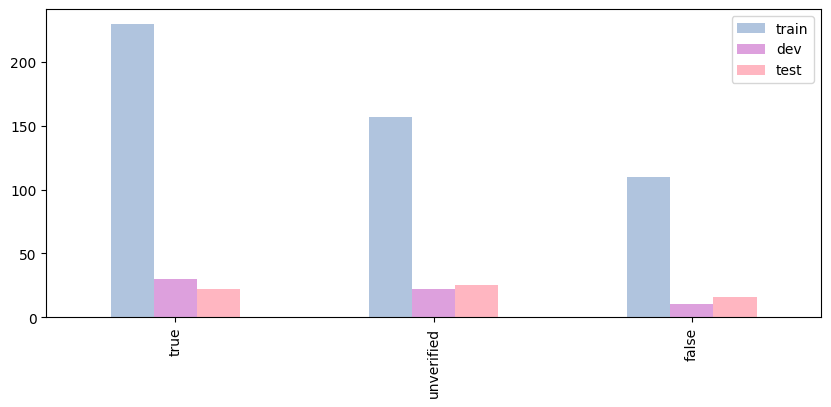

In [15]:
train_stats = y_train.value_counts()
train_stats = train_stats.rename("train")
dev_stats = y_dev.value_counts()
dev_stats =dev_stats.rename("dev")
test_stats = y_test.value_counts()
test_stats = test_stats.rename("test")

stats_df = pd.concat([train_stats, dev_stats, test_stats], axis=1)

color_dict = {"train": "Lightsteelblue", "dev": "plum", "test":"LightPink"}
plt = stats_df.plot(kind="bar", color=color_dict, figsize=(10, 4))
plt.figure.savefig('class_distribution.png', bbox_inches="tight")

#### Topic Distribution

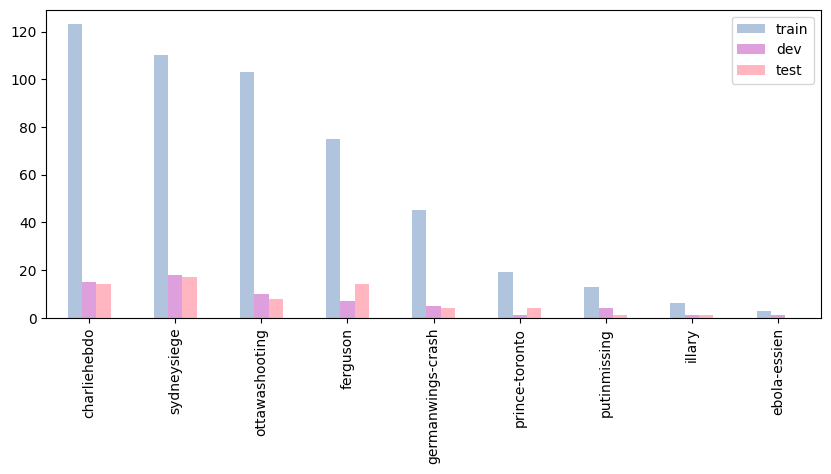

In [16]:
tweet_df = pd.read_csv("merged_data/tweets17-19.csv")
id_text_dict = dict(zip(tweet_df.id, tweet_df.text))
id_text_dict = {v: k for k, v in id_text_dict.items()}


X_train_df = X_train.to_frame()
X_train_df["id"] = X_train_df["text"].map(id_text_dict)
tmp = X_train_df["id"].str.split("_", expand=True)
X_train_df["topic"] = tmp[1]
topic_train = X_train_df.topic.value_counts()
topic_train.rename("train", inplace=True)

X_dev_df = X_dev.to_frame()
X_dev_df["id"] = X_dev_df["text"].map(id_text_dict)
tmp = X_dev_df["id"].str.split("_", expand=True)
X_dev_df["topic"] = tmp[1]
topic_dev = X_dev_df.topic.value_counts()
topic_dev.rename("dev", inplace=True)

X_test_df = X_test.to_frame()
X_test_df.rename(columns={0: "text"}, inplace=True)
X_test_df["id"] = X_test_df["text"].map(id_text_dict)
tmp = X_test_df["id"].str.split("_", expand=True)
X_test_df["topic"] = tmp[1]
topic_test = X_test_df.topic.value_counts()
topic_test.rename("test", inplace=True)

topic_df = pd.concat([topic_train, topic_dev, topic_test], axis=1)
plt = topic_df.plot(kind="bar", color=color_dict, figsize=(10, 4))
plt.figure.savefig('topic_distribution.png', bbox_inches="tight")

In [17]:
X_train_cleaned = clean(X_train)
X_dev_cleaned = clean(X_dev)
X_test_cleaned = clean(X_test)

In [18]:
X_train_tfidf, X_dev_tfidf, X_test_tfidf, vectorizer = vectorize(X_train, X_dev, X_test)

#### Encode the Labels

In [19]:
encoder = LabelEncoder()
# true = 1, false = 0, unverified = 2
y_train = encoder.fit_transform(y_train)
y_dev = encoder.transform(y_dev)
y_test = encoder.transform(y_test)


### Fine-tuning

In [20]:
# SVM
clf = train_SVM(X_train_tfidf, y_train)
print(clf.best_params_)

{'C': 5, 'kernel': 'sigmoid'}


In [21]:
dev_pred = clf.predict(X_dev_tfidf)
dev_prec, dev_rec, dev_f1 = evaluate(dev_pred, y_dev)
dev_acc = accuracy_score(y_dev, dev_pred)
print(f"DEV SET: \nAccuracy = {dev_acc},\nPrecision = {dev_prec},\nRecall = {dev_rec},\nF1 = {dev_f1}")

DEV SET: 
Accuracy = 0.9354838709677419,
Precision = 0.9520833333333334,
Recall = 0.9434343434343435,
F1 = 0.9467485919098823


### Predict Test data

In [22]:
test_pred = clf.predict(X_test_tfidf)
test_prec, test_rec, test_f1 = evaluate(test_pred, y_test)
test_acc = accuracy_score(y_test, test_pred)
rmse = sqrt(mean_squared_error(y_test, test_pred))
norm_acc = (1 - rmse)*test_acc
print(f"TEST SET: \nAccuracy = {test_acc},\nPrecision = {test_prec},\nRecall = {test_rec},\nF1 = {test_f1},\nRMSE = {rmse},\nNormalized Accuracy = {norm_acc}")

TEST SET: 
Accuracy = 0.9365079365079365,
Precision = 0.943030303030303,
Recall = 0.943030303030303,
F1 = 0.943030303030303,
RMSE = 0.25197631533948484,
Normalized Accuracy = 0.7005301173804824


### Predict Test data with new topics

In [23]:
# clean new test data
X_test2 = test_df["text"]
X_test2_cleaned = clean(X_test2)

In [24]:
# vectorize new test data
X_test2_tfidf = vectorizer.transform(X_test2_cleaned)

In [25]:
# encode labels
y_test2 = encoder.transform(test_df["label"])

In [35]:
# make predictions
test2_pred = clf.predict(X_test2_tfidf)
test2_prec, test2_rec, test2_f1 = evaluate(test2_pred, y_test2)
test2_acc = accuracy_score(y_test2, test2_pred) 
print(f"2.TEST SET: \nAccuracy = {test2_acc},\nPrecision = {test2_prec},\nRecall = {test2_rec},\nRMSE = {rmse2},\nNormalized Accuracy = {norm_acc2},\nF1 = {test2_f1}")

2.TEST SET: 
Accuracy = 0.44642857142857145,
Precision = 0.4210358056265984,
Recall = 0.4585858585858586,
RMSE = 1.0436885140144612,
Normalized Accuracy = -0.01950380089931302,
F1 = 0.39661344944363813


### More stats

#### Test Set

In [27]:
X_test_df["predictions"] = test_pred
X_test_df["true"] = y_test
X_test_df["label"] = encoder.inverse_transform(y_test)
X_test_df.drop("id", axis=1, inplace=True)

In [28]:
wrong_pred_test = X_test_df.loc[~(X_test_df['predictions'] == X_test_df['true'])]
wrong_pred_test.to_csv("results/misclassifications_test_set1.csv", sep=",")
wrong_pred_test

,text,topic,predictions,true,label
332,Rural region of northern France searched in hu...,charliehebdo,1,2,unverified
184,Statement from Ottawa Hospital: received 3 pat...,ottawashooting,1,2,unverified
379,Witness: Police allegedly stopped Mike Brown a...,ferguson,2,1,true
77,Witness: Police allegedly stopped Mike Brown a...,ferguson,2,1,true


#### Second Test Set

In [30]:
X_test2_df = X_test2.to_frame()
X_test2_df["predictions"] = test2_pred
X_test2_df["true"] = y_test2
X_test2_df["label"] = encoder.inverse_transform(y_test2)


In [31]:
wrong_pred_test2 = X_test2_df.loc[~(X_test2_df['predictions'] == X_test2_df['true'])]
wrong_pred_test2.to_csv("results/misclassifications_test_set2.csv", sep=";")
wrong_pred_test2

,text,predictions,true,label
0,#Breaking: Pentagon releases video of the “mot...,2,0,false
0,"ICYMI: ""Rep Sheila Jackson Lee (D-Tx) Wants Hu...",2,1,true
0,"In 2003, Houston U.S. Rep. Sheila Jackson Lee ...",2,1,true
0,Noah’s Ark Theme Park Destroyed in a Flood? ht...,1,0,false
0,My lasting impression of Barbara Bush was the ...,0,1,true
0,This is crazy! #CapeTown #capestorm #weatherfo...,1,0,false
0,Clinton camp delays Weather Channel ad buy aft...,0,1,true
0,Clinton camp delays Weather Channel ad buy aft...,0,1,true
0,Clinton camp delays Weather Channel ad buy aft...,0,1,true
0,REVERSING COURSE: Clinton camp delays Weather ...,0,1,true
